In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.callbacks import CSVLogger
import warnings
print("Tensorflow Edition:", tf.__version__)
seed = 2020
np.random.seed(seed)
tf.random.set_seed(seed)

warnings.filterwarnings('ignore')
%matplotlib inline

Tensorflow Edition: 2.4.1


In [ ]:
from google.colab import drive
#drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
DATA_PROJECT = '/content/drive/MyDrive/Project/Data/'
SAVE_PATH = '/content/drive/MyDrive/Project/Model/'

X_train = np.load(DATA_PROJECT+'train.npy')
X_train = X_train.astype(float)
y_train = np.load(DATA_PROJECT+'train_labels.npy')

X_valid = np.load(DATA_PROJECT+'valid.npy')
X_valid = X_valid.astype(float)
y_valid = np.load(DATA_PROJECT+'valid_labels.npy')

X_test = np.load(DATA_PROJECT+'test.npy')
X_test = X_test.astype(float)
y_test = np.load(DATA_PROJECT+'test_labels.npy')

X_list = [X_train, X_valid, X_test]
y_list = [y_train, y_valid, y_test]

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
from keras.layers import Conv1D, MaxPooling1D

In [ ]:
latent_dim = 128

encoder_inputs = keras.Input(shape=(101, 4))
x = Conv1D(32, 3, activation='relu', use_bias=True, padding='same')(encoder_inputs)
x = Conv1D(32, 3, activation='relu', use_bias=True, padding='same')(x)
x = MaxPooling1D(2, 2)(x)

x = Conv1D(64, 3, activation='relu', use_bias=True, padding='same')(x)
x = Conv1D(64, 3, activation='relu', use_bias=True, padding='same')(x)
x = MaxPooling1D(2, 2)(x)

x = Conv1D(128, 3, activation='relu', use_bias=True, padding='same')(x)
x = Conv1D(128, 3, activation='relu', use_bias=True, padding='same')(x)
x = MaxPooling1D(2, 2)(x)

x = layers.Flatten()(x)
#x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 101, 4)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 101, 32)      416         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 101, 32)      3104        conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 50, 32)       0           conv1d_1[0][0]                   
____________________________________________________________________________________________

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
#x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.Dense(101, activation="relu")(latent_inputs)
x = layers.Reshape((101, 1))(x)
x = layers.Conv1DTranspose(64, 3, activation="relu", padding="same")(x)
x = layers.Conv1DTranspose(32, 3, activation="relu", padding="same")(x)
decoder_outputs = layers.Conv1DTranspose(4, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               13029     
_________________________________________________________________
reshape_1 (Reshape)          (None, 101, 1)            0         
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 101, 64)           256       
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 101, 32)           6176      
_________________________________________________________________
conv1d_transpose_5 (Conv1DTr (None, 101, 4)            388       
Total params: 19,849
Trainable params: 19,849
Non-trainable params: 0
_______________________________________________________

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(0, 1)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
X_total = np.concatenate([X_train, X_test, X_valid], axis=0)
X_total.shape

(96914, 101, 4)

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(X_test[0:10000,:], epochs=1500, batch_size=32)

In [ ]:
'''
checkpoint_filepath = SAVE_PATH + 'VAE'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = False,
    monitor = 'loss',
    mode = 'max',
    save_best_only = True)
csv_logger = CSVLogger(checkpoint_filepath+'/train_history.csv', append=False)

_,_,z = vae.encoder.predict(X_train[0:1,:])
vae.decoder.predict(z)
model_single.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_valid, y_valid),
        verbose=2, callbacks=[model_checkpoint_callback, csv_logger])
'''

In [18]:
checkpoint_filepath = SAVE_PATH + 'VAE'
tf.saved_model.save(vae, checkpoint_filepath)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Project/Model/VAE/assets


In [14]:
_,_,z = vae.encoder.predict(X_test[0:10000,:])
np.save(DATA_PROJECT+'vae_encode.npy', z)

In [25]:
import matplotlib.pyplot as plt
def plot_decompose(encode, labels):
  model_name = 'VAE encode to 128 dimension'
  fig = plt.figure(3, figsize=[3*7, 7])
  axes = fig.subplots(1, 3)

  from sklearn.manifold import TSNE
  decomposer_tsne = TSNE(n_components=2)
  de_tsne = decomposer_tsne.fit_transform(encode)
  scatter = axes[0].scatter(x=de_tsne[:,0], y=de_tsne[:,1], c=labels)
  legend1 = axes[0].legend(*scatter.legend_elements(), loc="best", title="Classes")
  axes[0].set_title(model_name+'---Tsne')
  axes[0].add_artist(legend1)
  np.save(DATA_PROJECT+'vae_encode_tsne.npy', de_tsne)

  from sklearn.manifold import Isomap
  decomposer_iso = Isomap(n_components=2, n_neighbors=10)
  de_iso = decomposer_iso.fit_transform(encode)
  scatter = axes[1].scatter(x=de_iso[:,0], y=de_iso[:,1], c=labels)
  legend1 = axes[1].legend(*scatter.legend_elements(), loc="best", title="Classes")
  axes[1].set_title(model_name+'---Isomap')
  axes[1].add_artist(legend1)
  np.save(DATA_PROJECT+'vae_encode_isomap.npy', de_iso)

  from sklearn.decomposition import PCA
  decomposer_pca = PCA(n_components=2)
  de_pca = decomposer_pca.fit_transform(encode)
  scatter = axes[2].scatter(x=de_pca[:,0], y=de_pca[:,1], c=labels)
  legend1 = axes[2].legend(*scatter.legend_elements(), loc="best", title="Classes")
  axes[2].set_title(model_name+'---PCA')
  axes[2].add_artist(legend1)
  np.save(DATA_PROJECT+'vae_encode_pca.npy', de_pca)

  np.save(DATA_PROJECT+'vae_encode_labels.npy', labels)

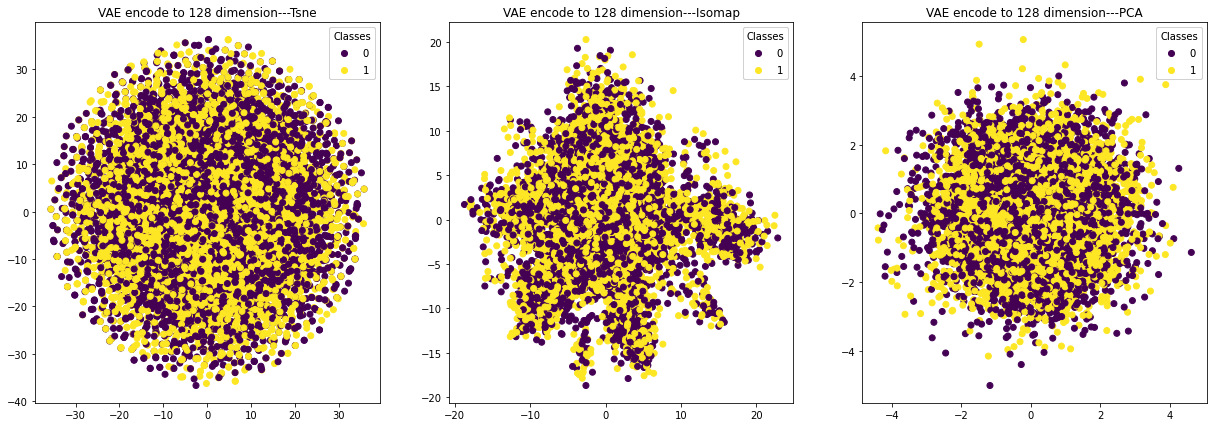

In [26]:
plot_decompose(z, y_test[0:10000])

In [31]:
np.load(DATA_PROJECT+'vae_encode_tsne.npy').shape

(10000, 2)

In [ ]:
while True:
  pass